<h1 style="font-size:3rem;color:orange;">Directing User Subscriptions📱</h1>

<h2 style="font-size:2rem;color:orange;">Data Pre-processing and Model Building</h2>

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import os

### Import Data

In [2]:
app_user_data_df = pd.read_csv("../data/processed/new_app-user-data.csv")

### Data Peek 👀

In [3]:
app_user_data_df.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,OtherScreens,CreditCardScreens,CreditMonitoringScreens,LoanScreens,SavingsScreens
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,0,7,0,0,1,0
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,5,0,0,1,0
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,6,0,3,1,0
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,0,10,0,2,1,0


In [4]:
app_user_data_df.describe()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,OtherScreens,CreditCardScreens,CreditMonitoringScreens,LoanScreens,SavingsScreens
count,49844.000000,49844.000000,49844.000000,49844.000000,49844.000000,49844.000000,49844.000000,49844.000000,49844.000000,49844.000000,...,49844.000000,49844.000000,49844.000000,49844.000000,49844.000000,49844.000000,49844.000000,49844.000000,49844.000000,49844.000000
mean,186897.636987,3.028730,12.559445,31.732425,20.824914,0.107756,0.172037,0.506520,0.165055,0.516973,...,0.014184,0.013342,0.013021,0.008165,0.007403,6.198620,0.173943,0.924805,0.787015,0.353342
std,107772.516054,2.032019,7.440927,10.806681,14.778043,0.310075,0.377416,0.499962,0.371234,0.499717,...,0.118251,0.114734,0.113364,0.089994,0.085723,3.655998,0.607022,1.215996,0.677037,1.378283
min,13.000000,0.000000,0.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,5.000000,24.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,187183.500000,3.000000,14.000000,29.000000,18.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,0.000000
75%,279996.000000,5.000000,19.000000,37.000000,28.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.000000,1.000000,0.000000
max,373662.000000,6.000000,23.000000,101.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,3.000000,5.000000,3.000000,10.000000


Here we generate an interactive [YData Profiling](https://docs.profiling.ydata.ai/4.6/) report of our processed data which we save to a HTML file 

In [5]:
%%capture
from ydata_profiling import ProfileReport

# The local directory to save the report
data_dir = '../data/processed'
if not os.path.exists(data_dir): os.makedirs(data_dir)

# Generate the report & save to a file
data_profile = ProfileReport(app_user_data_df, title="Profiling Report of new_app-user-data.csv")
data_profile.to_file(f'../data/processed/ProfileReport_new_app-user-data.html')

- To view in the notebook, create a new cell below with ```data_profile.to_notebook_iframe()```

- View the report in the web browser [here](https://ml-fintech-case-studies.netlify.app/profile_reports/new_app-user-data.html#overview) 👁️‍🗨️

  <img src="../../images/app_users_processed_profile-report.png" width="585" alt="ProfileReport"/>

In [6]:
# Restore matplotlib to inline mode after viewing for plots
%matplotlib inline

# Data Pre-processing <img src="../../images/processing.gif" width="40" alt="Processing">

### Remove the label from the features

In [7]:
label = app_user_data_df['enrolled']
app_user_data_df = app_user_data_df.drop(columns = 'enrolled')

### Feature Selection

The following function leverages a model's feature importance scores and [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) to calculate threshold scores for feature selection. We persist [results](../experiments/feature_thresholds/) to avoid duplicate runs.

In [8]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline

def get_threshold_scores(X_train, y_train, X_test, y_test, model, file_path, run_function):
    """
    Generates scores for feature importance thresholds to be used in feature selection.
    Accepts the training & test datasets, the trained model, the path to save the file, & a boolean to execute.
    Writes a CSV file with the threshold, number of remaining features, & model evaluation metrics.
    """
    if run_function == False: return
    results = []
    # Fit model using each importance as a threshold
    thresholds = sort(model.feature_importances_)
    for thresh in thresholds:
        # Select features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        # Apply selection to datasets
        select_X_train = selection.transform(X_train.values)
        select_X_test = selection.transform(X_test.values)
        num_features = select_X_train.shape[1]
        # Define the selection_model to use
        xgb_model = XGBClassifier(n_estimators=100, objective='binary:logistic', random_state=42)
        selection_model = Pipeline([('scaler', StandardScaler()), ('model', xgb_model)])
        # Train model
        selection_model.fit(select_X_train, y_train)
        # Evaluate model
        y_predict = selection_model.predict(select_X_test)
        prob_posclass = selection_model.predict_proba(select_X_test)[:, 1]
        accuracy = accuracy_score(y_test, y_predict)
        precision = precision_score(y_test, y_predict)
        recall = recall_score(y_test, y_predict)
        f1 = f1_score(y_test, y_predict)
        roc_auc = roc_auc_score(y_test, prob_posclass)
        # Results
        results.append([thresh, num_features, accuracy, precision, recall, f1, roc_auc])
        
    # Create a DataFrame from the results list
    column_names = ["Threshold", "Num_Features", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]
    threshold_results_df = pd.DataFrame(results, columns=column_names)
    # Save the DataFrame to a CSV file
    threshold_results_df.to_csv(file_path, index=False)  

### Transformations

In [9]:
# Take the log of 'numscreens' to address skew for linear models
app_user_data_df['log_numscreens'] = np.log(app_user_data_df['numscreens'])

# Drop the previous values 
app_user_data_df.drop('numscreens', axis=1, inplace=True)

### Split the dataset into training and test sets

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into an 80/20 train/test ratio
X_train, X_test, y_train, y_test = train_test_split(app_user_data_df, label,
                                                    test_size=0.2,
                                                    stratify=label, 
                                                    random_state=42)
print(X_train.shape)
print(X_test.shape)

(39875, 48)
(9969, 48)


### Filter model data

In [11]:
# Purge user identification, persist to associate the prediction to the user it came from 
train_identifier = X_train['user']
X_train = X_train.drop(columns = ['user'])

test_identifier = X_test['user']
X_test = X_test.drop(columns = ['user'])

### Pipeline

- Type Conversion

In [12]:
from sklearn.preprocessing import FunctionTransformer

def convert_to_float(df):
    df = df.astype(float)
    return df

preprocessing = FunctionTransformer(convert_to_float)

- Feature Scaling

In [13]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

# Model Building 🤖

### Training Data

In [14]:
# Split the training set into a 80/20 training/validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
                                                                test_size=0.2, 
                                                                stratify=y_train, 
                                                                random_state=42)
print(X_train.shape)
print(X_validation.shape)

(31900, 47)
(7975, 47)


### Training Data Combined

For cross-validation and final model training

In [15]:
# Concatenate the training and validation feature datasets vertically
X_train_and_validation = pd.concat([X_train, X_validation], axis=0).reset_index(drop=True)

# Concatenate the training and validation label datasets vertically
y_train_and_validation = pd.concat([y_train, y_validation], axis=0).reset_index(drop=True)

### Metrics Function

In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def evaluate_scores_and_concat(prob_posclass, y_test, y_predict, model_name, results_dataframe): 
    """
    Evaluates model scores and concatenates results to a DataFrame.
    """
    # Get scores
    accuracy = accuracy_score(y_test, y_predict)   # CorrectPredicts/TotalPredicts  
    precision = precision_score(y_test, y_predict) # TP/(TP+FP)
    recall = recall_score(y_test, y_predict)       # TP/(TP+FN)
    f1 = f1_score(y_test, y_predict)               # 2*(precision*recall)/(precision+recall)
    roc_auc = roc_auc_score(y_test, prob_posclass)
    # Transfer scores to a DataFrame
    new_results = pd.DataFrame([[model_name, accuracy, precision, recall, f1, roc_auc]],
                       columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'])
    # Concatenate results to the results_dataframe vertically
    results_dataframe = pd.concat([results_dataframe, new_results], axis=0).reset_index(drop=True)
    
    return results_dataframe

## Logistic Regression 📈

### Training

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Penalty 'l1' Lasso regularization
lr_model = LogisticRegression(penalty='l1', solver='saga', random_state=42)

lr_pipeline_model = Pipeline([('preprocessing', preprocessing), ('scaler', standard_scaler), ('model', lr_model)])

lr_pipeline_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 FunctionTransformer(func=<function convert_to_float at 0x7fd86cefcb80>)),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(penalty='l1', random_state=42,
                                    solver='saga'))])

In [18]:
# Initialize a results DataFrame
df_results = pd.DataFrame()

### Evaluation

In [19]:
from sklearn.model_selection import cross_val_score

# Make predictions from the validation set
y_predict = lr_pipeline_model.predict(X_validation)

# Predict the probabilities of the positive class
prob_posclass = lr_pipeline_model.predict_proba(X_validation)[:, 1]

# Get model scores
df_results = evaluate_scores_and_concat(prob_posclass, y_validation, y_predict, 'LogisticRegression (Lasso)', df_results)

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=lr_pipeline_model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
df_results

Cross Validated Accuracy: 76.47%
Confidence Interval: +- 1.31%



,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression (Lasso),0.759875,0.763524,0.761822,0.762672,0.83459


## Random Forest Classifier 🌳

### Training

In [20]:
from sklearn.ensemble import RandomForestClassifier

# 100 Trees
rf_model = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)

rf_pipeline_model = Pipeline([('preprocessing', preprocessing), ('scaler', standard_scaler), ('model', rf_model)])

rf_pipeline_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 FunctionTransformer(func=<function convert_to_float at 0x7fd86cefcb80>)),
                ('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(criterion='entropy', random_state=42))])

### Evaluation

In [21]:
# Make predictions from the validation set
y_predict = rf_pipeline_model.predict(X_validation)

# Predict the probabilities of the positive class
prob_posclass = rf_pipeline_model.predict_proba(X_validation)[:, 1]

# Get model scores
df_results = evaluate_scores_and_concat(prob_posclass, y_validation, y_predict, 'RandomForestClassifier (n=100)', df_results)

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=rf_model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
df_results

Cross Validated Accuracy: 77.79%
Confidence Interval: +- 1.49%



,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression (Lasso),0.759875,0.763524,0.761822,0.762672,0.834590
1,RandomForestClassifier (n=100),0.774796,0.786024,0.763060,0.774372,0.856446


## XGBoost Classifier 🚀


### Training

In [22]:
from xgboost import XGBClassifier

# 100 Stages
xgb_model = XGBClassifier(n_estimators=100, objective='binary:logistic', random_state=42)

xgb_pipeline_model = Pipeline([('preprocessing', preprocessing), ('scaler', standard_scaler), ('model', xgb_model)])

xgb_pipeline_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 FunctionTransformer(func=<function convert_to_float at 0x7fd86cefcb80>)),
                ('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=No...one,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

### Evaluation

In [23]:
# Make predictions from the validation set
y_predict = xgb_pipeline_model.predict(X_validation)

# Predict the probabilities of the positive class
prob_posclass = xgb_pipeline_model.predict_proba(X_validation)[:, 1]

# Get model scores
df_results = evaluate_scores_and_concat(prob_posclass, y_validation, y_predict, 'XGBClassifier (n=100)', df_results)

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=xgb_pipeline_model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
df_results

Cross Validated Accuracy: 77.84%
Confidence Interval: +- 1.22%



,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression (Lasso),0.759875,0.763524,0.761822,0.762672,0.834590
1,RandomForestClassifier (n=100),0.774796,0.786024,0.763060,0.774372,0.856446
2,XGBClassifier (n=100),0.770909,0.784905,0.754395,0.769347,0.856280


## Save Data 💾

In [24]:
# Create a directory to save results
directory = "../experiments/baseline_metrics"
if not os.path.exists(directory): os.makedirs(directory)

df_results.to_csv(f"{directory}/baseline_metrics_002.csv", index=False)

## Baseline Model Evaluation <img src="../../images/charts.gif" width="43" alt="Chart Bars"/>

Here we continue with a further evaluation of the [XGBClassifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) algorithm as a baseline model

In [25]:
# Define model
pipeline_model = xgb_pipeline_model

### Confusion Matrix

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def sklearn_confusion_matrix(y_test, y_predict, model):
    """
    Generates a scikit-learn confusion matrix. 
    Accepts the test labels, the predicted labels, and the trained model.
    Displays the plot.
    """
    if isinstance(model, Pipeline): model = model.named_steps['model']
    # Create a confusion matrix with the labels and our model's predictions
    conf_matrix = confusion_matrix(y_test, y_predict)
    # Create the plot
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    ax.set(title='Confusion Matrix for Predicting Loan E-Signature Model')
    display.plot(ax=ax, cmap='Blues', values_format='d')
    plt.show()

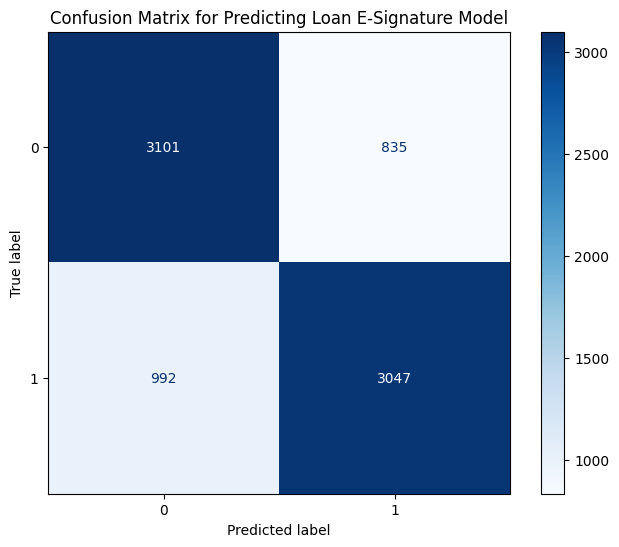

              precision    recall  f1-score   support

           0      0.758     0.788     0.772      3936
           1      0.785     0.754     0.769      4039

    accuracy                          0.771      7975
   macro avg      0.771     0.771     0.771      7975
weighted avg      0.771     0.771     0.771      7975



In [27]:
from sklearn.metrics import classification_report

# Make predictions
y_predict = pipeline_model.predict(X_validation)

# Plot confusion matrix & display classification report
sklearn_confusion_matrix(y_validation, y_predict, pipeline_model)
print(classification_report(y_validation, y_predict, digits=3))

### Receiver Operating Characteristic (ROC) Curve

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn.objects as so

def plot_roc_curve(X_test, y_test, model):
   """
   Function for plotting the ROC Curve.
   Accepts the test features, test labels, and the trained model.
   Displays the plot and returns the AUC score. 
   """
   # Generate data for a 45 degree line
   noskill_probabilities = [0 for number in range(len(y_test))]
   # Predict the probabilities of the positive class
   probabilities_posclass = model.predict_proba(X_test)[:, 1]
   # Calculate data for horizontal line
   falsepositive_rate_noskill, truepositive_rate_noskill, _ = roc_curve(y_test, noskill_probabilities)
   # Calculate data for ROC curve
   falsepositive_rate, truepositive_rate, _ = roc_curve(y_test, probabilities_posclass)
   # Calculate AUC
   roc_auc = roc_auc_score(y_test, probabilities_posclass)
   # Display AUC
   print("AUC (Area Under the ROC Curve): {:.2f}".format(roc_auc))
   # Plot with Seaborn Objects
   plt = (so.Plot()
      .add(so.Line(color='red'), x =falsepositive_rate, y=truepositive_rate)
      .add(so.Line(color='blue', linestyle='dashed'), x=falsepositive_rate_noskill, y=truepositive_rate_noskill)
      .layout(size = (8,5))
      )
   plt.show()
   
   return roc_auc

AUC (Area Under the ROC Curve): 0.86


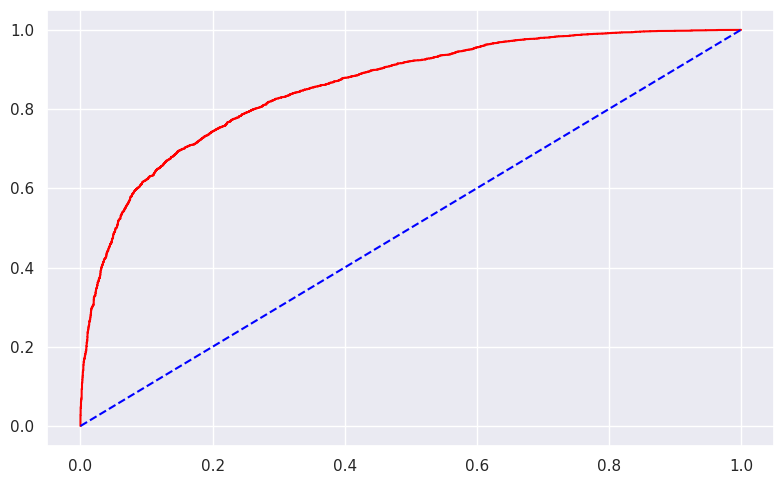

In [29]:
roc_auc = plot_roc_curve(X_validation, y_validation, pipeline_model)

We note the model's discriminatory power is very good

### Feature Importances

In [30]:
from sklearn.pipeline import Pipeline

def plot_feature_importance(X_train, model):
    """
    Plots feature importances from a model.
    Accepts the training features DataFrame and the trained model.
    Displays the plot and returns a DataFrame of features and their importance scores.
    """
    if isinstance(model, Pipeline): model = model.named_steps['model']
      
    # Extract feature names from the DataFrame
    features = X_train.columns.tolist()
    # Create a DataFrame with feature names and their importance
    feature_df = pd.DataFrame({
      'Feature': features,
      'Importance': model.feature_importances_
      })
    # Sort the DataFrame by importance in descending order
    feature_df = feature_df.sort_values(by='Importance', ascending=False)
    # Adjust figure size as needed
    plt.figure(figsize=(10, 20)) 
    plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis() # Place highest importance at top
    plt.show()

    return feature_df

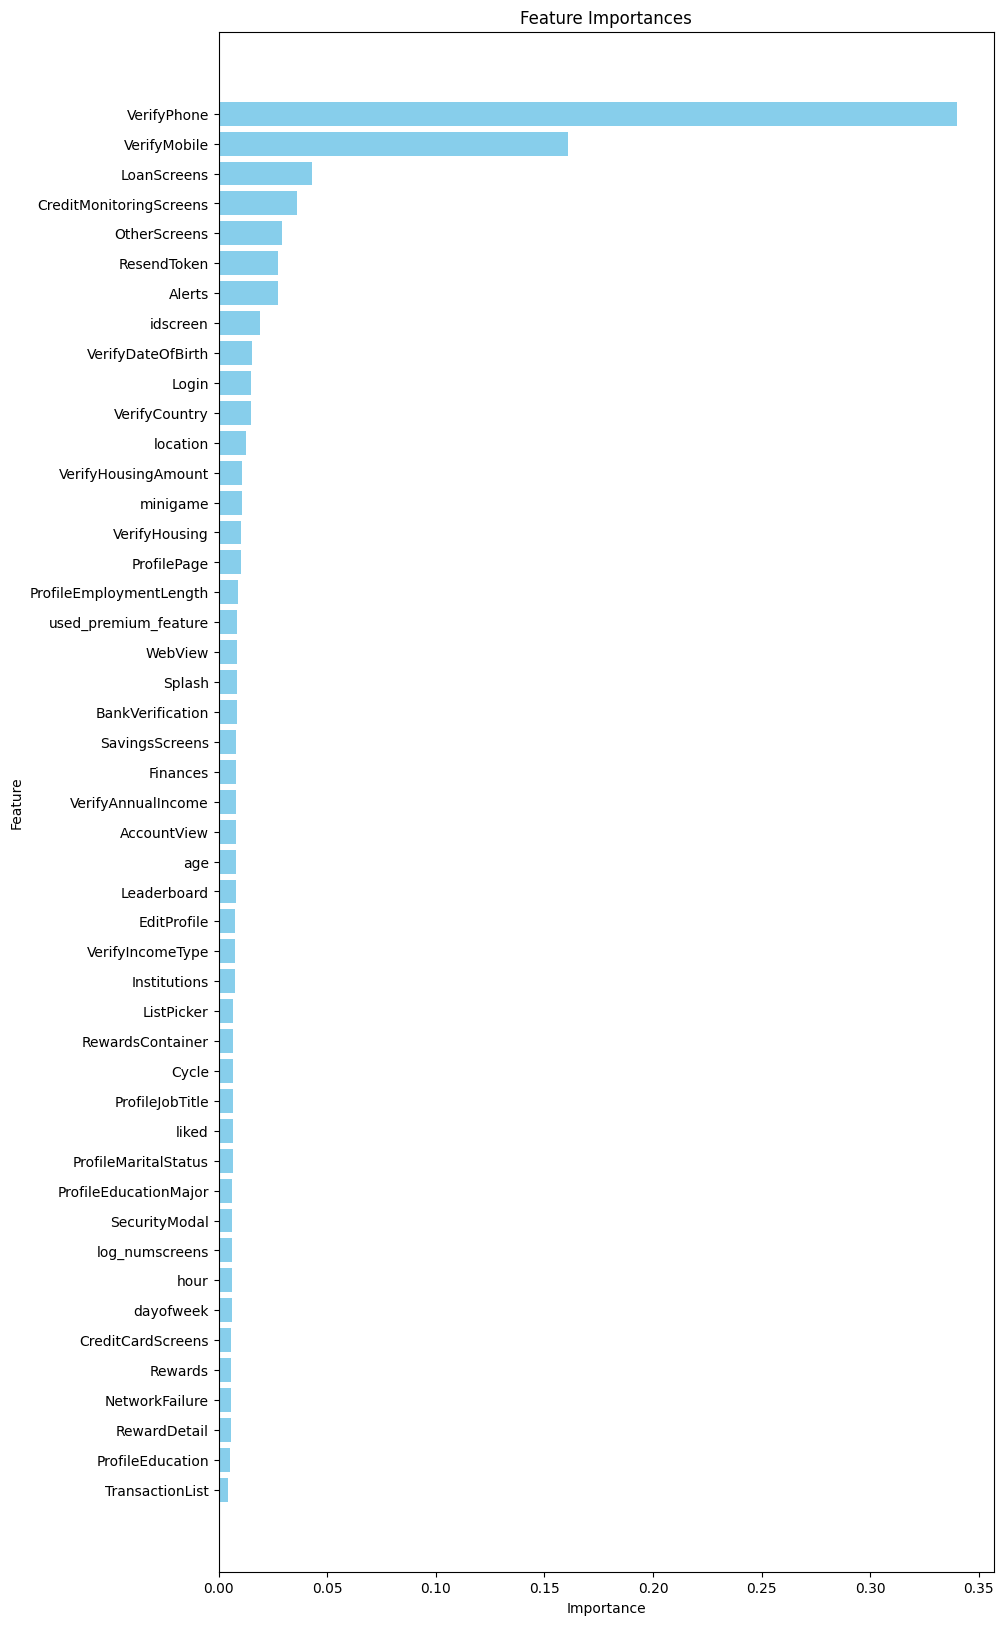

,Feature,Importance
8,VerifyPhone,0.339775
21,VerifyMobile,0.160815
44,LoanScreens,0.042962
43,CreditMonitoringScreens,0.035935
41,OtherScreens,0.029013
37,ResendToken,0.027558
19,Alerts,0.027280
14,idscreen,0.018973
10,VerifyDateOfBirth,0.015322
33,Login,0.014994


In [31]:
feature_df = plot_feature_importance(X_train, pipeline_model)
# Adjust as needed
feature_df.head(10)

### Feature Selection

- Generate Threshold Scores

In [32]:
# Create a directory to save results
directory = "../experiments/feature_thresholds"
if not os.path.exists(directory): os.makedirs(directory)

file_name = f"{directory}/xgb_feat_threshold_scores.csv"

# Prepare the data
X_train_floats = convert_to_float(X_train)
X_val_floats = convert_to_float(X_validation)

get_threshold_scores(X_train_floats, y_train, X_val_floats, y_validation, pipeline_model.named_steps['model'], file_name, False)

- Inspect Results

In [33]:
threshold_results_df = pd.read_csv(file_name)

# Set the display format for float values to 10 decimal places
pd.set_option('display.float_format', '{:.10f}'.format)

# Adjust for full list
threshold_results_df.head()

,Threshold,Num_Features,Accuracy,Precision,Recall,F1,ROC_AUC
0,0.0045522675,47,0.7709090909,0.7849046883,0.7543946521,0.7693473046,0.8562804891
1,0.0054445890,46,0.7710344828,0.7868809956,0.7514236197,0.7687436677,0.8560305127
2,0.0055741705,45,0.7732915361,0.7860989997,0.7588512008,0.7722348199,0.8565410646
3,0.0057759834,44,0.7732915361,0.7863928113,0.7583560287,0.7721199899,0.8569076944
4,0.0058625606,43,0.7678996865,0.7805128205,0.7536518940,0.7668472100,0.8550839805


In [34]:
# Reset display option to default value
pd.reset_option('display.float_format')

- Select Features 

In [35]:
threshold = 0.0074664390	

# Define features under the threshold to remove
features_to_remove_df = feature_df[feature_df['Importance'] < threshold]
columns_to_drop = features_to_remove_df['Feature'].values.tolist()

print(columns_to_drop)

['ListPicker', 'RewardsContainer', 'Cycle', 'ProfileJobTitle', 'liked', 'ProfileMaritalStatus', 'ProfileEducationMajor', 'SecurityModal', 'log_numscreens', 'hour', 'dayofweek', 'CreditCardScreens', 'Rewards', 'NetworkFailure', 'RewardDetail', 'ProfileEducation', 'TransactionList']


In [36]:
# Drop the features from the datasets
X_train.drop(columns=columns_to_drop, axis=1, inplace=True)
X_validation.drop(columns=columns_to_drop, axis=1, inplace=True)
X_train_and_validation.drop(columns=columns_to_drop, axis=1, inplace=True)
X_test.drop(columns=columns_to_drop, axis=1, inplace=True)

print("Number of Features: ", X_train.shape[1])

Number of Features:  30


- Retraining & Evaluation

In [37]:
pipeline_model.fit(X_train, y_train)

# Make predictions from the validation set
y_predict = pipeline_model.predict(X_validation)
# Predict the probabilities of the positive class
prob_posclass = pipeline_model.predict_proba(X_validation)[:, 1]
# Get model scores
df_results = evaluate_scores_and_concat(prob_posclass, y_validation, y_predict, f"XGBClassifier (n=100, feat_thresh={threshold})", df_results)
# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=pipeline_model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
df_results

Cross Validated Accuracy: 78.03%
Confidence Interval: +- 1.41%



,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression (Lasso),0.759875,0.763524,0.761822,0.762672,0.834590
1,RandomForestClassifier (n=100),0.774796,0.786024,0.763060,0.774372,0.856446
2,XGBClassifier (n=100),0.770909,0.784905,0.754395,0.769347,0.856280
3,"XGBClassifier (n=100, feat_thresh=0.007466439)",0.779060,0.797959,0.754890,0.775827,0.857646


We observe an improvement in our scores as a result of feature selection and continue with hyperparameter optimization

## Model Tuning <img src="../../images/tuning.gif" width="50" alt="Tuning"/>

Here we utilize Hyperopt for model tuning to take advantage of Bayesian Optimization 

- We begin by initializing MLflow to document our [experiment](../experiments/README.md) 🧪

In [38]:
# Define location to save experiments
experiment_dir = "../experiments/mlflow_demo"
if not os.path.exists(experiment_dir): os.makedirs(experiment_dir)
    
# Define location to save artifacts
artifacts_dir = f"{experiment_dir}/artifacts"
if not os.path.exists(artifacts_dir): os.makedirs(artifacts_dir)

In [39]:
from pathlib import Path
import random

# 5 digit random number for the experiment
random_number = random.randint(10_000, 99_999)
# Set the tracking server URI 
mlflow.set_tracking_uri(f"sqlite:///{os.path.abspath(experiment_dir)}/mlflow.sqlite")
# Create a new experiment
EXPERIMENT_ID = mlflow.create_experiment(f"hyperopt_tuning_{random_number}",
                                         artifact_location=Path.cwd().joinpath(f"{artifacts_dir}").as_uri(), 
                                         tags={"version": "v1"})
# Fetch experiment details
experiment = mlflow.get_experiment(EXPERIMENT_ID)

print(f"Name: {experiment.name}")
print(f"Experiment_id: {experiment.experiment_id}")
print(f"Artifact Location: file://{experiment_dir}/{experiment.experiment_id}")
print(f"Tags: {experiment.tags}")
print(f"Lifecycle_stage: {experiment.lifecycle_stage}")
print(f"Creation timestamp: {experiment.creation_time}")

Name: hyperopt_tuning_48667
Experiment_id: 9
Artifact Location: file://../experiments/mlflow_demo/9
Tags: {'version': 'v1'}
Lifecycle_stage: active
Creation timestamp: 1699672322110


- Define the objective function

In [40]:
from hyperopt import STATUS_OK
from mlflow.models.signature import infer_signature
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

def objective_function(space):
    """
    The objective function for Hyperopt. 
    Accepts the hyperparameter search space & returns a loss score to minimize. 
    Logs metadata & the model from best trials.
    """
    # Define & train model
    xgb_model = XGBClassifier(**space, random_state=42)
    pipeline_model = Pipeline([('preprocessing', preprocessing), ('scaler', standard_scaler), ('model', xgb_model)])
    pipeline_model.fit(X_train, y_train)
    # Predict values & positive class probabilities for the validation set
    y_val_predict = pipeline_model.predict(X_validation)
    probabilities_posclass = pipeline_model.predict_proba(X_validation)[:, 1]
    # Evaluation metrics
    val_accuracy = accuracy_score(y_validation, y_val_predict)
    val_precision = precision_score(y_validation, y_val_predict, zero_division=0)
    val_recall = recall_score(y_validation, y_val_predict)
    val_f1 = f1_score(y_validation, y_val_predict)
    val_roc_auc = roc_auc_score(y_validation, probabilities_posclass)
    
    validation_metrics = {
      "accuracy": val_accuracy, 
      "precision": val_precision, 
      "recall": val_recall, 
      "F1": val_f1, 
      "roc_auc": val_roc_auc
    }
    
    with mlflow.start_run(experiment_id=experiment.experiment_id):
        model = pipeline_model.named_steps['model']
        mlflow.log_params(space)
        mlflow.log_params({"validation_feature_importances": model.feature_importances_})
        for name, metric in validation_metrics.items():
            mlflow.log_metric(f"validation_{name}", metric)
        signature = infer_signature(X_train, y_val_predict)
        mlflow.sklearn.log_model(pipeline_model, 
                                 artifact_path="model", 
                                 signature=signature, 
                                 input_example=X_train.iloc[[0]], 
                                 pip_requirements="./requirements.txt")
        mlflow.set_tag("estimator_name", model.__class__.__name__)
        mlflow.set_tag("estimator_class", model.__class__)
        mlflow.end_run()
    
    # Here we aim to maximize roc_auc, thus return it as a negative value
    return {'loss': -val_roc_auc, 'status': STATUS_OK}

- Define the search space

In [41]:
from hyperopt import hp
from hyperopt.pyll.base import scope

search_space = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 10)),
    'max_depth': scope.int(hp.quniform('max_depth', 4, 12, 1)),
    'subsample': hp.uniform('subsample', .5, 1.0),
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 7),
    'reg_alpha': hp.loguniform('reg_alpha', -10, 10),
    'reg_lambda': hp.loguniform('reg_lambda', -10, 10),
    'gamma': hp.loguniform('gamma', -10, 10),
    'use_label_encoder': False,
    'verbosity': 0,
    }

- Run Hyperopt. _For optimal (or fastest) results, see [suggested formulas](https://www.databricks.com/blog/2021/04/15/how-not-to-tune-your-model-with-hyperopt.html). This may take some time, go have some tea_ 

In [42]:
from hyperopt import fmin, tpe, Trials

# Demo number of trials, adjust for utilization
num_evals = 5
trials = Trials()

best_hyperparam = fmin(fn=objective_function, 
                       space=search_space, 
                       algo=tpe.suggest, # Bayesian search w/ Tree Parzen Estimator (TPE)
                       max_evals=num_evals, 
                       trials=trials, 
                       rstate=np.random.default_rng(42)
                       ) 

print(best_hyperparam)

100%|██████████| 5/5 [00:52<00:00, 10.54s/trial, best loss: -0.8585816364631831]
{'gamma': 1.6717454718446907, 'learning_rate': 0.4667529468841399, 'max_depth': 11.0, 'min_child_weight': 35.93906811331547, 'n_estimators': 240.0, 'reg_alpha': 10.519356386632165, 'reg_lambda': 0.00019809190050441863, 'subsample': 0.5734813936425138}


#### MLflow Functions

In [43]:
def get_best_scoring_model(metric_name, ascending_boolean, experiment_dir, experiment_ID, database_name):
    """
    Returns a model with the best scoring metric from MLflow. 
    Accepts the metric name, an ascending order boolean (False=Higher Scores, True=Lower Scores),
    path to the directory hosting the experiment, the experiment_id, and SQLite database name.
    Returns the model with the best scoring metric from MLflow. 
    """
    # Set the tracking server URI, here configred for SQLite backend storage
    mlflow.set_tracking_uri(f"sqlite:///{os.path.abspath(experiment_dir)}/{database_name}")
    # Get the experiment_id 
    experiment_id = experiment_ID
    # Get runs from the experiment
    runs = mlflow.search_runs(experiment_ids=[experiment_id], filter_string='', max_results=1000)
    # Filter the runs for best desired metric
    best_run = runs.sort_values(f"metrics.{metric_name}", ascending=ascending_boolean).iloc[0]
    # Provide the model URI
    best_model_uri = best_run["artifact_uri"] + "/model"
    # Modify this line to your flavor of model: sklearn, spark, xgboost, pytorch, tensorflow, etc.
    # Pipeline model => sklearn
    pipeline_model = mlflow.sklearn.load_model(best_model_uri)
    model = pipeline_model.named_steps['model']
    
    print("Best Scoring Run ID:", best_run.run_id)
    print("Model Type:", type(model).__name__)
    print("Model Hyperparameters: ", model.get_params())
    
    return pipeline_model

In [44]:
def get_model(experiment_dir,run_id, database_name):
    """
    Returns a model logged with MLflow.
    Accepts a path to the directory hosting the experiment and run_id.
    """
    # Set the tracking server URI, here configred for SQLite backend storage
    mlflow.set_tracking_uri(f"sqlite:///{os.path.abspath(experiment_dir)}/{database_name}")
    # Specify model URI
    model_uri = f"runs:/{run_id}/model" 
    # Modify this line to your flavor of model: sklearn, spark, xgboost, pytorch, tensorflow, etc.
    # Pipeline model => sklearn
    model = mlflow.sklearn.load_model(model_uri)
    
    return model

### K-Fold Cross Validation

Estimate how well the tuned model is likely to generalize to unseen data

In [45]:
# Active experiment_ID => experiment.experiment_id
experiment_ID = "6"
# Active experiment_dir => experiment_dir
experiment_dir = "../experiments/mlflow_xgb"

# Load the best scoring model from the experiment 
pipeline_model = get_best_scoring_model("validation_roc_auc", False, experiment_dir, experiment_ID, "mlflow.sqlite")

Best Scoring Run ID: 4f3517701f1249d099b348e24f6270c0
Model Type: XGBClassifier
Model Hyperparameters:  {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'auc', 'feature_types': None, 'gamma': 4.796809661299055, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.0380212481902716, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': 0.5475493506156135, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 400, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': 0.0012652117975919936, 'reg_lambda': 4.267688039164066, 'sampling_method': None, 'scale_pos_weight': N

In [46]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=pipeline_model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
print(accuracies)

Cross Validated Accuracy: 78.59%
Confidence Interval: +- 1.63%

[0.77156469 0.7998997  0.78961886 0.78686058 0.77407222 0.78580386
 0.79082017 0.79408076 0.7848006  0.78179082]


## Final Model Training 🦾

Load the model from MLflow 

In [47]:
experiment_dir = "../experiments/mlflow_xgb"
run_id = "4f3517701f1249d099b348e24f6270c0"

pipeline_model = get_model(experiment_dir, run_id, "mlflow.sqlite")

In [48]:
# Train model on the train & validation data
pipeline_model.fit(X_train_and_validation, y_train_and_validation)

Pipeline(steps=[('preprocessing',
                 FunctionTransformer(func=<function convert_to_float at 0x7fd826632830>)),
                ('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=N...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0380212481902716, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None,
                               min_child_weight=0.5475493506156135, missing=nan,
                               monotone_constraints=None, n_estimators=400,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

## Final Model Evaluation <img src="../../images/charts.gif" width="43" alt="Chart Bars"/>

In [49]:
# DataFrame for storing metrics
df_final_metrics = pd.DataFrame()

In [50]:
# Make predictions from the test set
y_predict = pipeline_model.predict(X_test)

# Predict probabilities of the positive class
prob_posclass = pipeline_model.predict_proba(X_test)[:, 1]

# Model info
model_type = type(pipeline_model.named_steps['model']).__name__
run_id = str(run_id) if run_id else "(tuned)"

# Get model scores
df_final_metrics = evaluate_scores_and_concat(prob_posclass, y_test, y_predict, f"{model_type} {run_id[:6]}...", df_final_metrics)
df_final_metrics

,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,XGBClassifier 4f3517...,0.784632,0.80309,0.761584,0.781787,0.864444


### Confusion Matrix

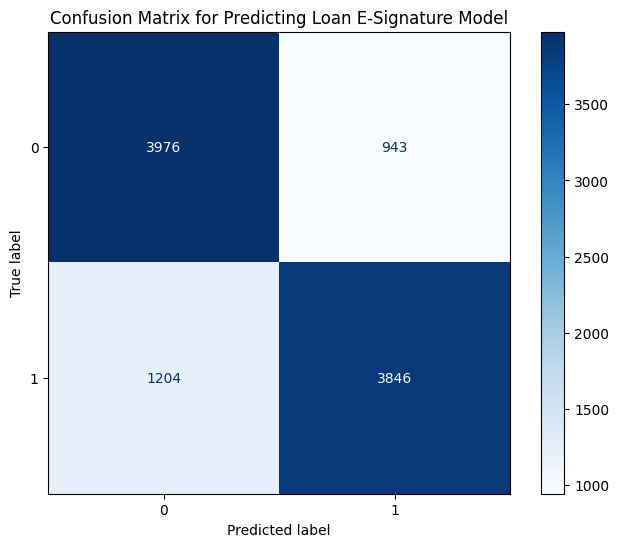

              precision    recall  f1-score   support

           0    0.76757   0.80829   0.78740      4919
           1    0.80309   0.76158   0.78179      5050

    accuracy                        0.78463      9969
   macro avg    0.78533   0.78494   0.78460      9969
weighted avg    0.78556   0.78463   0.78456      9969



In [51]:
# Plot confusion matrix & display classification report
sklearn_confusion_matrix(y_test, y_predict, pipeline_model)
print(classification_report(y_test, y_predict, digits=5))

### Receiver Operating Characteristic (ROC) Curve

AUC (Area Under the ROC Curve): 0.86


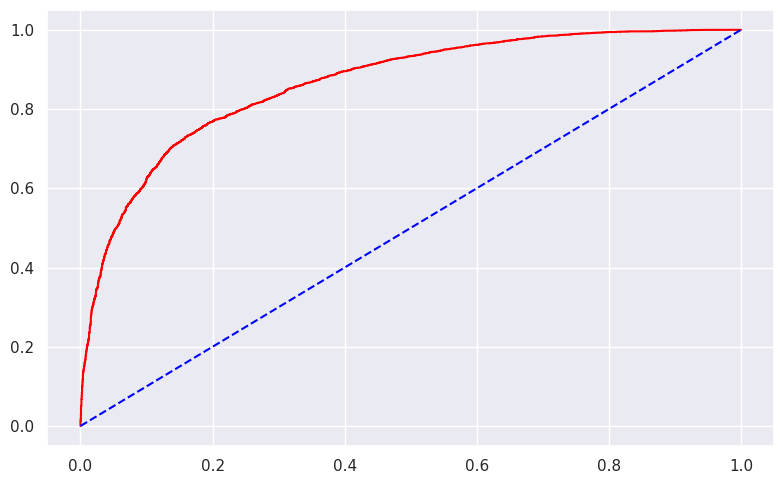

In [52]:
roc_auc = plot_roc_curve(X_test, y_test, pipeline_model)

### Feature Importances

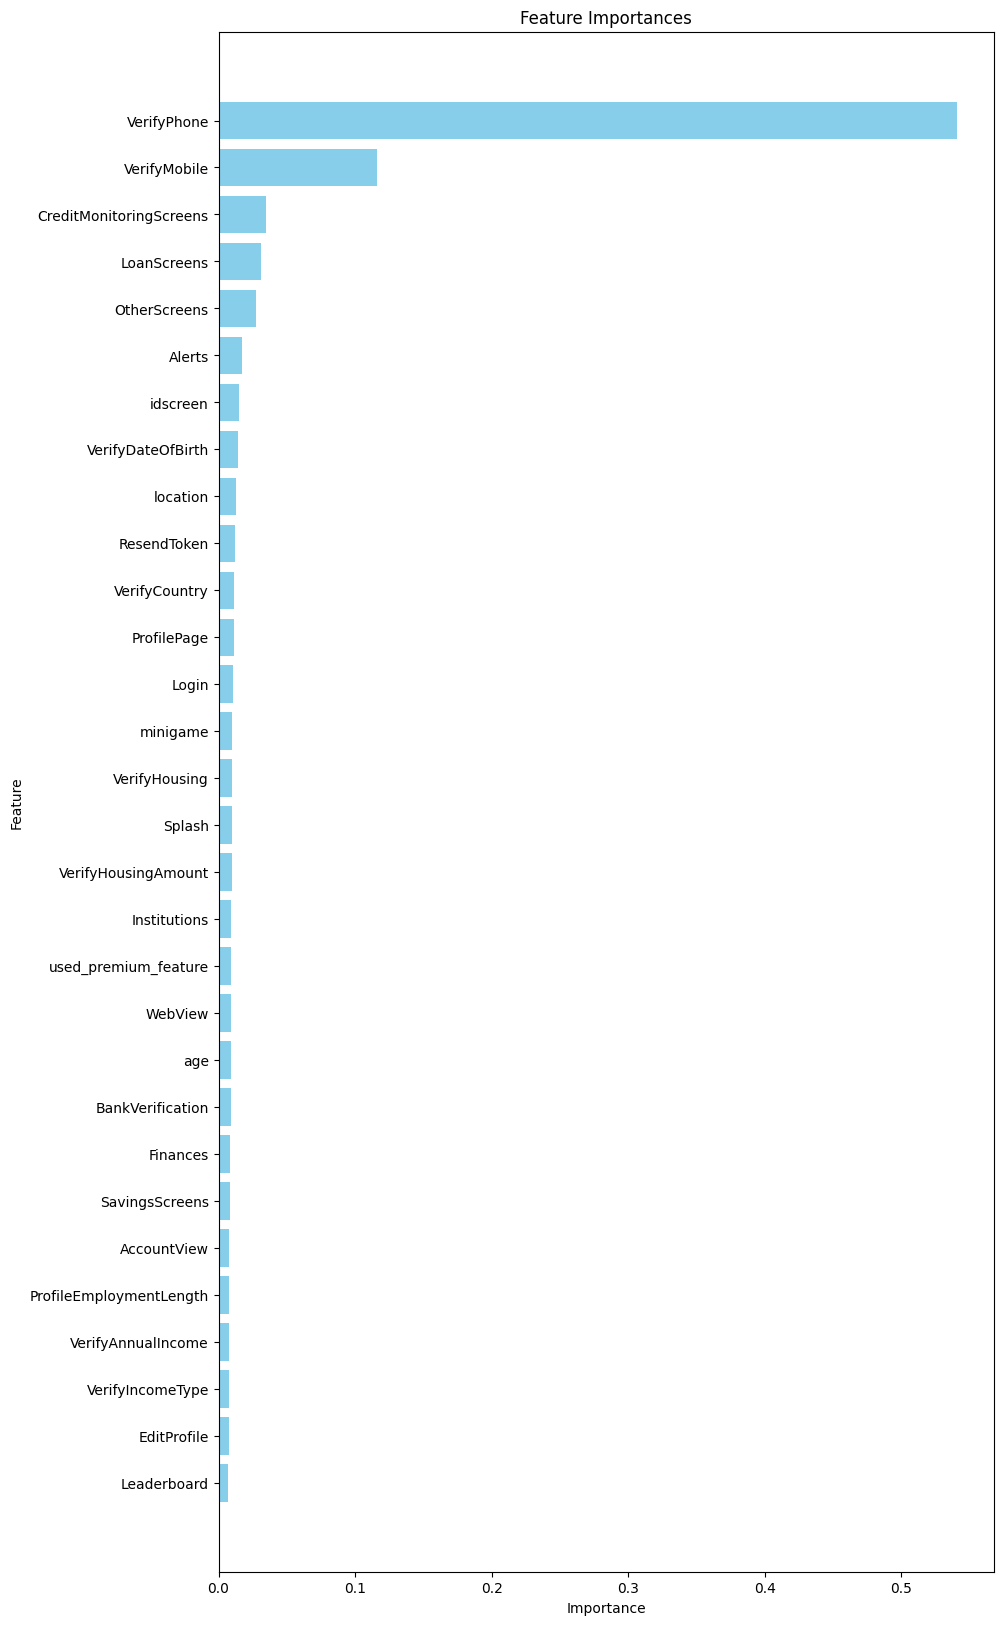

,Feature,Importance
5,VerifyPhone,0.540509
16,VerifyMobile,0.116004
27,CreditMonitoringScreens,0.034553
28,LoanScreens,0.031354
26,OtherScreens,0.027180
14,Alerts,0.016846
10,idscreen,0.015190
7,VerifyDateOfBirth,0.014444
3,location,0.012472
25,ResendToken,0.011930


In [53]:
feature_df = plot_feature_importance(X_train_and_validation, pipeline_model)
# Adjust as needed
feature_df.head(10)

## Save Model 💾

Next we save the optimized model along with associated metrics, metadata, and artifacts

In [54]:
# Create a directory to save sample training data 
sample_dir = "../data/samples"
if not os.path.exists(sample_dir): os.makedirs(sample_dir)
    
type_of_model = type(pipeline_model.named_steps['model']).__name__
    
# Create a directory to save the model
model_dir = f"../models/{type_of_model}"
if not os.path.exists(model_dir): os.makedirs(model_dir)

In [55]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import random

random_number = random.randint(10_000, 99_999)

# Set the tracking server URI, here set to file storage
mlflow.set_tracking_uri(f'file://{os.path.abspath(model_dir)}')

# Set the experiment
experiment_name = "final_models"
experiment = mlflow.set_experiment(experiment_name)

# Save a sample of the data the model was trained on
sample_data = X_train.head()
sample_data.to_csv(f"{sample_dir}/sample_train_data_{random_number}.csv", index=False)

model = pipeline_model.named_steps['model']

# Get model hyperpameters
model_params = model.get_params()
params_dict = dict(model_params)

# Predict the probabilities of the positive class
prob_posclass = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, prob_posclass)

with mlflow.start_run(experiment_id=experiment.experiment_id):
    mlflow.log_params(params_dict)
    mlflow.log_params({"test_feature_importances": model.feature_importances_})
    mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_predict))
    mlflow.log_metric("test_precision", precision_score(y_test, y_predict))
    mlflow.log_metric("test_recall", recall_score(y_test, y_predict))
    mlflow.log_metric("test_F1", f1_score(y_test, y_predict))
    mlflow.log_metric("test_roc_auc", roc_auc)
    mlflow.sklearn.log_model(pipeline_model, "model", pip_requirements="./requirements.txt")
    mlflow.set_tag("estimator_name", model.__class__.__name__)
    mlflow.set_tag("estimator_class", model.__class__)
    mlflow.log_artifact(f"{sample_dir}/sample_train_data_{random_number}.csv")
    mlflow.end_run()

## Process Results 🔄

Here we format the final results from our model's predictions to the user this data came from. While we will not have 'enrolled' data for the deployed model's predictions in the future, a similar process can be applied. This enables the company is able to identify users who are predicted not to enroll in paid subscriptions to the application after completing the free trial and experiment with different methods of converting them.

In [56]:
# Concatenate test labels to the user they came from
final_results_df = pd.concat([y_test, test_identifier], axis=1).dropna()
# Add predicted results from the model
final_results_df['predicted_results'] = y_predict
final_results_df = final_results_df[['user', 'enrolled', 'predicted_results']].reset_index(drop=True)

# Adjust as needed
final_results_df.head(10)

,user,enrolled,predicted_results
0,49321,0,0
1,260324,0,0
2,279577,0,0
3,20758,1,1
4,76492,1,1
5,32728,0,0
6,239012,0,0
7,218344,1,1
8,66162,0,0
9,286539,1,0


### Save Data 💾

Persist final results and a list of users our model has estimated to be unlikely to enroll in the paid subscription

In [57]:
from datetime import datetime
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table
import csv

# Define a directory to save results 
directory = "../data/results"
if not os.path.exists(directory): os.makedirs(directory)

# Process a timestamp
datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# Save final results to a .csv file 
final_results_df.to_csv(f"../data/results/final_results_{datetime}.csv")

# Filter results for users unlikely to enroll in the paid subscription
final_results_df = final_results_df[final_results_df.predicted_results == 0].copy()
unlikely_to_esign_df = final_results_df.copy().drop(columns = ['enrolled', 'predicted_results'])
# Save the filtered DataFrame to a .csv file
unlikely_to_esign_df.to_csv(f"../data/results/users_unlikely_to_enroll_{datetime}.csv")
# Define paths for conversion
csv_file = f"../data/results/users_unlikely_to_enroll_{datetime}.csv"
pdf_file = f"../data/results/users_unlikely_to_enroll_{datetime}.pdf"

# Convert the .csv file 
data = []
with open(csv_file, 'r') as file:
    reader = csv.reader(file)
    for row in reader: data.append(row)

# Create a PDF document
doc = SimpleDocTemplate(pdf_file, pagesize=letter)
# Create a table from the CSV data
table = Table(data)
# Add the table to the document
doc.build([table])